In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.patches as mpatches
import matplotlib.colors as mcolours
import matplotlib.colorbar as mcolorbar
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy import stats
from configparser import ConfigParser
import json
import seaborn as sns
import matplotlib.cm as cm
from prettytable.colortable import ColorTable, Themes, Theme
import numpy as np
from math import pi

from awpy.visualization.plot import plot_map, position_transform
from awpy.data import MAP_DATA

from analysis import load_doorway_data, load_smoke_data, assign_doorways

Read config.ini file

In [ ]:
config = ConfigParser()
config.read("data\\config.ini")

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams.update({'font.size': 18})

In [ ]:
DEMO_DIR = config["Data"]["demo_directory"]
FIGURES_DIR = config["Data"]["demo_directory"] + "\\figures"
DATASET_FILE = "data\\dataset.json"

MAP_SCALE = MAP_DATA["de_mirage"]["scale"]
SMOKE_RADIUS_SCALED = float(config["Data"]["smoke_radius_units"]) / MAP_DATA["de_mirage"]["scale"]

GREEN_TABLE_THEME = Theme(
    default_color="92",
    vertical_color="34",
    horizontal_color="34",
    junction_color="92",
)

In [ ]:
red_val = float(config["Visualisation"]["red_coverage_threshold"])
orange_val = float(config["Visualisation"]["orange_coverage_threshold"])
green_val = float(config["Visualisation"]["green_coverage_threshold"])

cvals  = [red_val, orange_val, green_val]
colors = ["#FF5151","#FFC881","#73FA7E"]

tuples = list(zip(cvals, colors))

NORM=plt.Normalize(0,100)
COVERAGE_CMAP = mcolours.LinearSegmentedColormap.from_list("", tuples)


In [ ]:
def plot_all_smokes(rounds, map_name, map_type="simpleradar", dark=True):
    '''Simple function which plots all smokes thrown during a game on the minimap'''
    fig, a = plot_map(map_name=map_name, map_type=map_type, dark=dark)
    fig.set_size_inches(18.5, 10.5)
    smoke_colour = config["Visualisation"]["smoke_colour"]
    for r in rounds:
        if r["grenades"]:
            for g in r["grenades"]:
                end_x = position_transform(map_name, g["grenadeX"], "x")
                end_y = position_transform(map_name, g["grenadeY"], "y")
                if g["grenadeType"] == "Smoke Grenade":
                    smoke_circle = plt.Circle(
                        (end_x, end_y), SMOKE_RADIUS_SCALED, alpha=0.2, color=smoke_colour)
                    a.add_artist(smoke_circle)
    plt.show()
    return fig

In [ ]:
def draw_introduction_figures():
    '''Generates the figures used in the introduction'''
    parser = DemoParser()
    inf_game = parser.read_json(
        json_path=DEMO_DIR + "\\misc\\introduction_demos\\natus-vincere-vs-g2-m1-inferno.json")
    mirage_game = parser.read_json(
        json_path=DEMO_DIR + "\\misc\\introduction_demos\\natus-vincere-vs-g2-m2-mirage.json")
    inf_diagram = plot_all_smokes(inf_game["gameRounds"], "de_inferno")
    inf_diagram.savefig(FIGURES_DIR + '\\inferno_smoke_map.png', dpi=100)
    mir_diagram = plot_all_smokes(mirage_game["gameRounds"], "de_mirage")
    mir_diagram.savefig(FIGURES_DIR + '\\mirage_smoke_map.png', dpi=100)

In [ ]:
def transform(value, axis):
    '''Wrapper function to call the transform function from awpy with map set to mirage by default'''
    return position_transform("de_mirage", value, axis)

In [ ]:
def overlay_doorway_image(fig, a, radius=False):
    '''Draws figure to show location of manually collected doorways and their detection zones'''

    doorways = load_doorway_data()
    door_col = config["Visualisation"]["doorway_colour"]

    # Two iterations to ensure draw order is correct for alpha when overlapping
    if radius:
        for doorway in doorways:
            # Plots a circle representing the detection radius of the doorway
            mp_x_scaled = transform(doorway.midpoint.x, "x")
            mp_y_scaled = transform(doorway.midpoint.y, "y")
            detection_r = config["Data"]["detection_radius_units"]
            detection_r_scaled = int(detection_r) / MAP_SCALE
            
            color = "white"
            for offset in range(0, 40, 10):
                a.add_artist(plt.Circle((mp_x_scaled, mp_y_scaled), detection_r_scaled-offset, alpha=0.15, color=color))
                color = "red" if color == "white" else "white"

    # Plots a yellow line with shadow for each doorway
    for doorway in doorways:
        xs = [transform(doorway.vector1.x, "x"), transform(doorway.vector2.x, "x")]
        ys = [transform(doorway.vector1.y, "y"), transform(doorway.vector2.y, "y")]
        shadow = [path_effects.SimpleLineShadow(shadow_color="black", linewidth=8, 
            alpha=0.6, offset=(3, -3)),path_effects.Normal()]
        a.plot(xs, ys, color=door_col, linewidth=8, solid_capstyle='round', 
            path_effects=shadow)

    # Adds legend to show yellow lines are doorways
    doorway_rep = mpatches.Patch(color=door_col, label="Doorway")
    plt.legend(handles=[doorway_rep], prop={'size': 22}, loc='upper left')

def draw_door_image():
    fig, a = plot_map(map_name="de_mirage", map_type="simpleradar")
    fig.set_size_inches(15, 15)
    overlay_doorway_image(fig, a, radius=True)
    save_loc = FIGURES_DIR + '\\doorway_locations.png'
    fig.savefig(save_loc, dpi=300)
    plt.show()


In [ ]:
def draw_abstract_representation(doorway, smoke, plot_radius=False):
        plt.rcParams.update({'font.size': 16})
        plt.rcParams['font.family'] = 'sans-serif'
        plt.rcParams['font.sans-serif'] = ['Helvetica']
        fig1 = plt.figure()
        fig1.set_size_inches(12, 12)
        ax1 = fig1.add_subplot(111, aspect='equal')

        spacing = 6

        # Plots the doorway
        x_values = [doorway.vector1.x, doorway.vector2.x]
        y_values = [doorway.vector1.y, doorway.vector2.y]
        ax1.plot(x_values, y_values, 'bo', linestyle='dashed')
        ax1.text(doorway.vector1.x + spacing, doorway.vector1.y,
                 f"D1\n({doorway.vector1.x}, {doorway.vector1.y})", horizontalalignment='left',
                 verticalalignment='center')
        ax1.text(doorway.vector2.x + spacing, doorway.vector2.y,
                 f"D2\n({doorway.vector2.x}, {doorway.vector2.y})", horizontalalignment='left',
                 verticalalignment='center')

        # Plots the radius line
        if plot_radius:
            x_values = [smoke.vector.x, smoke.vector.x-smoke.radius]
            y_values = [smoke.vector.y, smoke.vector.y]
            ax1.plot(x_values, y_values, marker="o",
                     color='grey', linestyle="solid")
            ax1.text(smoke.vector.x - smoke.radius/2, smoke.vector.y - spacing*2,
                     f"Smoke radius\n({smoke.radius} units)", horizontalalignment='center',
                     verticalalignment='center')

        # Plots the smoke
        plt.plot(smoke.vector.x, smoke.vector.y, marker="o", markersize=5, markeredgecolor="black",
                 markerfacecolor="black")

        smoke_circle = plt.Circle(
            (smoke.vector.x, smoke.vector.y), smoke.radius, alpha=1, color="black", linewidth=4, fill=False)
        ax1.text(smoke.vector.x, smoke.vector.y+spacing*2, f"Smoke\n({smoke.vector.x}, {smoke.vector.y})", horizontalalignment='center',
                 verticalalignment='center')

        ax1.add_patch(smoke_circle)
        ax1.autoscale_view()

In [ ]:
def draw_representation_cases():
    '''Draws Figure to show all cases possible in the 2D abstract representation'''
    plt.rcParams.update({'font.size': 16})
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(
        2, 3, sharex=True, sharey=True)
    plt.autoscale(True)
    fig.set_size_inches(18, 12)
    subplots = [ax1, ax2, ax3, ax4, ax5, ax6]
    smoke_radius = int(config['Data']['smoke_radius_units'])
    for plot in subplots:
        plot.set_aspect('equal')
        plot.add_patch(plt.Circle(
            (200, 200), smoke_radius, color="black", linewidth=4, fill=False))
    x_values = [150, 400]
    y_values = [10, 110]
    ax1.plot(x_values, y_values, 'bo', linestyle='dashed')
    ax1.set_title("1. No collision")
    x_values = [100, 25]
    y_values = [300, 400]
    ax2.plot(x_values, y_values, 'bo', linestyle='dashed')
    ax2.set_title("2. No collision\n(would if doorway extended)")
    x_values = [50, 350]
    y_values = [72, 72]
    ax3.plot(x_values, y_values, 'bo', linestyle='dashed')
    ax3.set_title("3. Doorway tangent to smoke")
    x_values = [200, 400]
    y_values = [200, 250]
    ax4.plot(x_values, y_values, 'bo', linestyle='dashed')
    ax4.set_title("4. Gap on one side")
    x_values = [75, 300]
    y_values = [280, 310]
    ax5.plot(x_values, y_values, 'bo', linestyle='dashed')
    ax5.set_title("5. Gaps on both sides")
    x_values = [125, 275]
    y_values = [250, 150]
    ax6.plot(x_values, y_values, 'bo', linestyle='dashed')
    ax6.set_title("6. Doorway fully covered")
    plt.show()

In [ ]:
def dataset_heatmaps(overlay_doors=False):
    with open(DATASET_FILE, 'r') as f:
        smokes = json.load(f)
    x = [transform(smoke["grenadeX"], "x") for smoke in smokes if smoke["grenadeX"] <= 1000 and smoke["grenadeY"] <= 1000]
    y = [transform(smoke["grenadeY"], "y") for smoke in smokes if smoke["grenadeX"] <= 1000 and smoke["grenadeY"] <= 1000]

    fig, a = initialise_map_plot()
    sns.kdeplot(x=x, y=y, shade=True, cmap="turbo", alpha=0.5, bw_adjust=0.35, levels=125, ax=a)
    if not overlay_doors:
        plt.savefig(FIGURES_DIR + "\\kde_plot_smoke_density.png", dpi=300)
    else:
        overlay_doorway_image(fig, a)
        plt.savefig(FIGURES_DIR + "\\kde_plot_smoke_density_doors.png", dpi=300)
    plt.show()

    fig, a = initialise_map_plot()
    kde = stats.gaussian_kde([x,y])
    z = kde([x,y])
    c = cm.turbo((z-z.min())/(z.max()-z.min()))
    a.scatter(x,y,marker='o',facecolors=c,s=1)
    if not overlay_doors:
        plt.savefig(FIGURES_DIR + "\\scatter_plot_smoke_density.png", dpi=300)
    else:
        overlay_doorway_image(fig, a)
        plt.savefig(FIGURES_DIR + "\\scatter_plot_smoke_density_doors.png", dpi=300)

    plt.show()

def initialise_map_plot():
    fig, a = plot_map(map_name="de_mirage", map_type="simpleradar")
    fig.set_size_inches(15, 15)
    plt.xlim([0, 1000])
    plt.ylim([1000, 0])
    return fig, a

def print_coverage_stats(valid_smokes, doorways):
    overall_table = ColorTable(theme=GREEN_TABLE_THEME)
    overall_table.field_names = ["Min(%)", "Mean(%)", "Max(%)", "Std(%)"]
    coverages = [smoke.coverage for smoke in valid_smokes]
    overall_table.add_row([np.min(coverages), np.mean(
        coverages), np.max(coverages), np.std(coverages)])
    overall_table.float_format = '.2'
    print(overall_table)

    doorway_table = ColorTable(theme=GREEN_TABLE_THEME)
    doorway_table.field_names = [
        "Doorway", "Frequency", "Min(%)", "Mean(%)", "Max(%)", "Std(%)"]

    for doorway in doorways:
        dw_cov = [smoke.coverage for smoke in doorway.smokes]
        doorway_table.add_row([doorway.name, len(doorway.smokes), np.min(
            dw_cov), np.mean(dw_cov), np.max(dw_cov), np.std(dw_cov)])
    doorway_table.float_format = '.2'
    print(doorway_table)


def mean_bar_charts(doorways):
    doorway_names = [doorway.name.replace("-", "\n") for doorway in doorways]
    mean_coverage = [doorway.coverage_stats()["mean"] for doorway in doorways]

    fig, ax = plt.subplots()
    ax.bar(doorway_names, mean_coverage)
    plt.show()

In [ ]:
def example_team_performance(valid_dataset, demo, team):
    fig, a = initialise_map_plot()
    smokes = [smoke for smoke in valid_dataset if smoke.demo_id == demo and smoke.team == team]

    team_averages = ColorTable(Theme=GREEN_TABLE_THEME)
    team_averages.field_names = ["Player", "Average Coverage"]
    players = set(smoke.thrower for smoke in smokes)
    for player in players:
        player_avg = np.mean([smoke.coverage for smoke in smokes if smoke.thrower == player])
        team_averages.add_row([player, player_avg])
    team_averages.add_row(["----------", "----------"])
    team_averages.add_row(["Team Average", np.mean([smoke.coverage for smoke in smokes if smoke.team == team])])
    team_averages.float_format = '.2'   
    print(team_averages)

    for smoke in smokes:
            x_scaled = transform(smoke.vector.x, "x")
            y_scaled = transform(smoke.vector.y, "y")
            a.add_artist(plt.Circle((x_scaled, y_scaled), SMOKE_RADIUS_SCALED, alpha=0.8, color=COVERAGE_CMAP(NORM(smoke.coverage))))
    
    divider = make_axes_locatable(plt.gca())
    ax_cb = divider.new_horizontal(size="5%", pad=0.1)    
    cb1 = mcolorbar.ColorbarBase(ax_cb, cmap=COVERAGE_CMAP, orientation='vertical', label="Percentage Coverage")
    plt.gcf().add_axes(ax_cb)
    plt.show()


In [31]:
def example_player_performance(doorways, player, colour):
    labels, values = ([] for _ in range(2))

    for doorway in doorways:
        coverages = [smoke.coverage for smoke in doorway.smokes if smoke.thrower==player]
        if len(coverages) != 0:
            labels.append(doorway.name.replace("-", "\n"))
            values.append(np.mean(coverages))

    N = len(labels)
    values += values[:1]
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    plt.figure(figsize=(15, 15))
    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], labels, color='grey', size=24)
    ax.tick_params(axis='x', which='major', pad=45)
    ax.set_rlabel_position(0)
    plt.yticks([25,50, 75], ["25", "50", "75"], color="grey", size=16)
    plt.ylim(0,100)

    ax.plot(angles, values, color=colour, alpha=0.5, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=colour, alpha=0.15)

    plt.show()

In [ ]:
smokes = load_smoke_data()
doorways = load_doorway_data()
valid_smokes = assign_doorways(smokes, doorways)

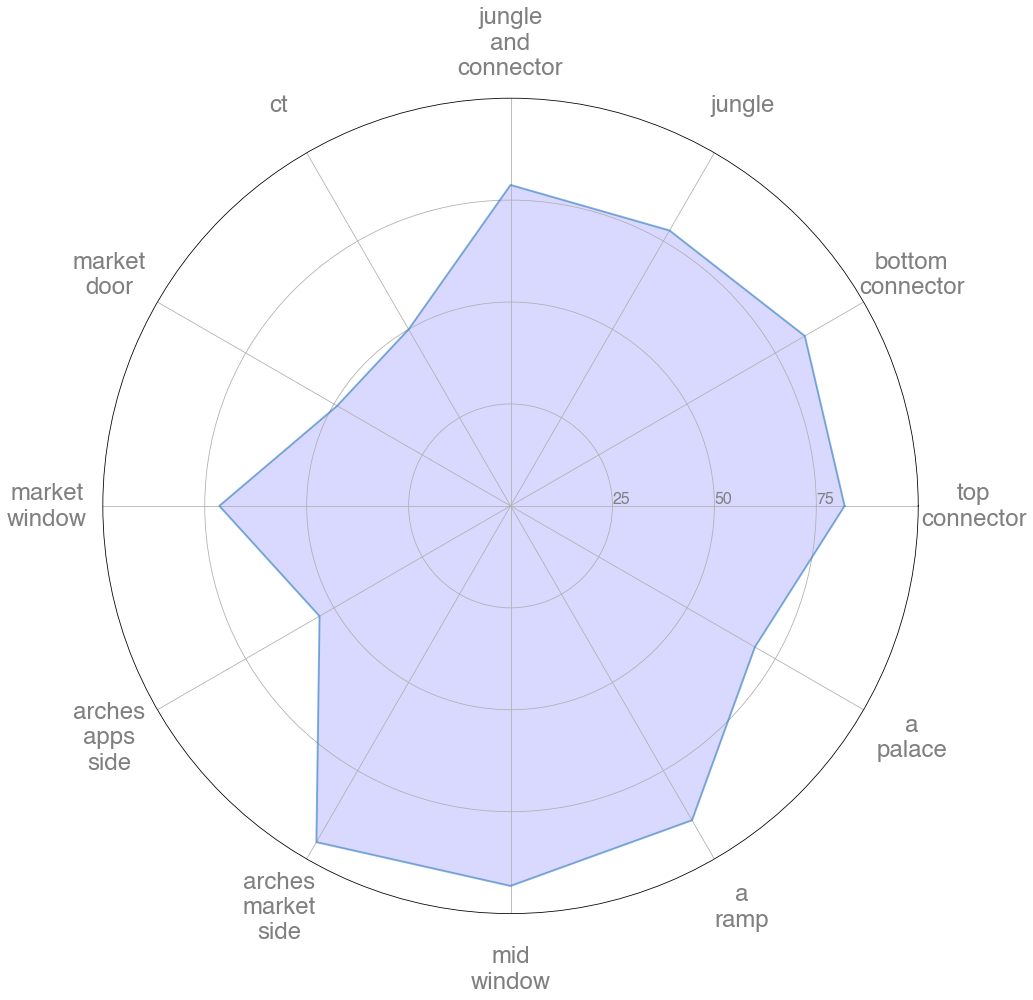

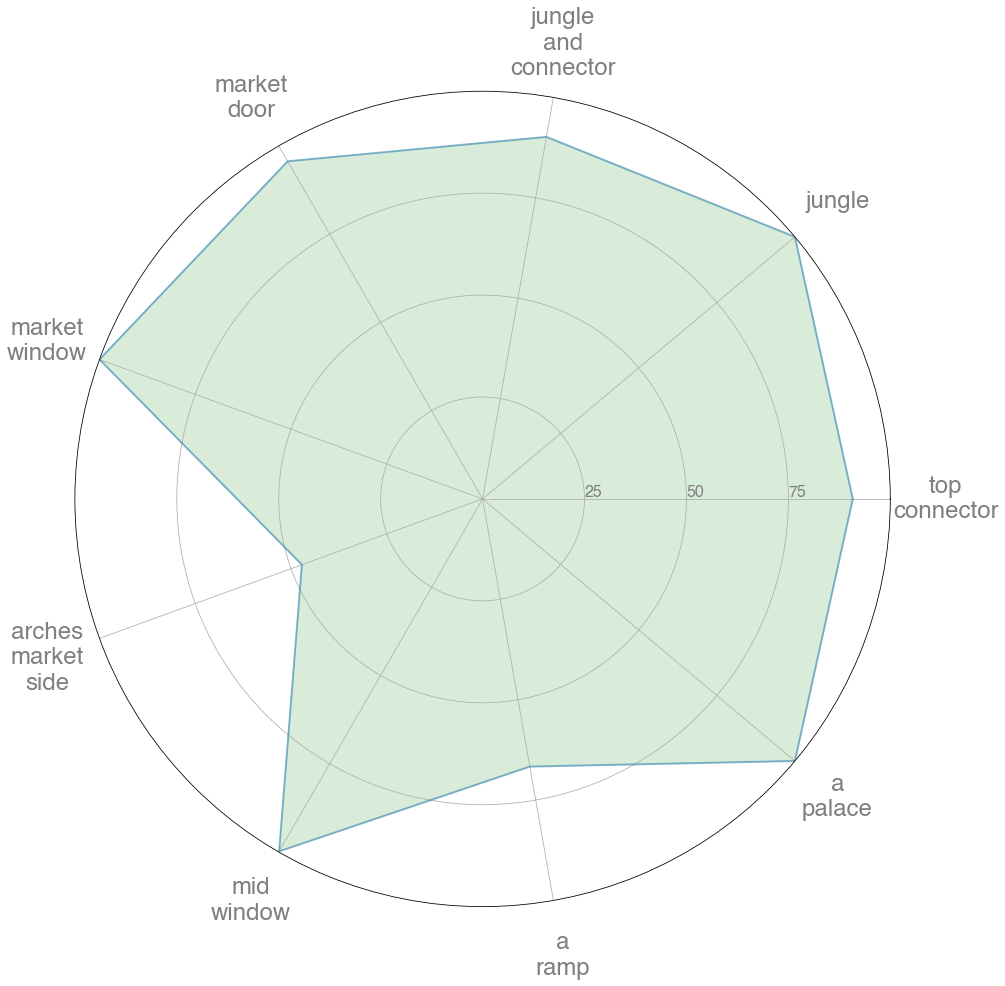

In [32]:
example_player_performance(doorways, "Twistzz", "blue")
example_player_performance(doorways, "Xyp9x", "green")

In [ ]:
# demo_id = "BLAST-Premier-Fall-Final-2021-astralis-vs-faze-bo3-mirage"
# example_team_performance(valid_smokes, demo=demo_id, team="Astralis")
# example_team_performance(valid_smokes, demo=demo_id, team="FaZe Clan")

In [ ]:
# print_dataset_stats(smokes)
# print_dataset_stats(valid_smokes)
# print_coverage_stats(valid_smokes, doorways)

In [ ]:
# dataset_heatmaps(overlay_doors=True)

In [ ]:
# draw_door_image()